# Analysing Pressure Data from an RBR Pressure Transducer

This notebook provides a comprehensive analysis pipeline for working with pressure data from an RBR pressure transducer, commonly used in marine and coastal research to monitor underwater pressure fluctuations associated with wave dynamics. The steps in this notebook will guide you through:

1. **Data Conversion**: We’ll start by converting raw data from the RBR device format into a user-friendly CSV format, facilitating further analysis in Python.
2. **Spectral Analysis**: Conducting spectral analysis on the pressure data to identify wave heights and frequencies.
3. **Data Visualisation**: Visualising the pressure data over time, helping to identify trends, anomalies, or distinct wave patterns in the dataset. 
4. **Energy Spectra Plotting**: Finally, we will plot the energy spectra in the frequency domain, providing insight into the distribution of wave energy across different frequencies and enabling a more detailed understanding of wave conditions.

By the end of this notebook, you’ll gain insights into wave characteristics in the measured region, including wave height, period, and energy distribution. This workflow can be adapted and applied to various pressure transducer datasets to support further studies in coastal and oceanographic science.




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Import the necessary libraries:

The utils module contains the additional functions need for this notebook

Remember: if you encounter an import error or ModuleNotFoundError you can use pip install to install the missing module. You might need to restart the Karnel (in the command bar).

## Step 1: Convert Raw RSK Data to CSV Format

The data is stored in an RSK file, which contains information collected by the sensor.
We use the `pyrsktools` package to read the RSK file and convert the data into a CSV file for further analysis.

#### _Note: this can also be done in the manufacturer’s software, **RBR Ruskin**: [rbr-global.com/products/software](https://rbr-global.com/products/software)._


Workflow Summary:
- Read raw sensor data from the RSK file.
- Process the data to calculate important parameters, including sea pressure, depth, and velocity.
- Export the processed data to a CSV file for easy access.

Metadata Extraction:
- Print metadata from the RSK file to understand the sensor setup and data collection conditions.

Methods used:
- `rsk.readdata()`: Reads the complete data set from the RSK file, making it available for processing.
- `rsk.deriveseapressure()`: Calculates sea pressure from the total pressure data. This adjusts for atmospheric pressure, providing a more accurate pressure reading at a given depth in seawater.
- `rsk.derivedepth()`: Converts sea pressure data into depth measurements, offering insights into the vertical positioning of data points within the water column.
- `rsk.derivevelocity()`: Calculates water velocity from the pressure data. The calculation method depends on the specific sensor settings and configuration.


In [2]:
# We will not do this in the interest of time

'''
rsk = pyrsktools.RSK('data/RBR_PT..rsk')
#Open the RSK file. Metadata is read here
with rsk as rsk:
    # Print a list of all the channels in the RSK file
    rsk.printchannels()
    # Read data
    rsk.readdata()
    # Derive sea pressure from total pressure
    rsk.deriveseapressure()
    rsk.derivedepth()
    rsk.derivevelocity()
    #Make csv
    rsk.RSK2CSV()
    print(rsk.logs)
    print('')
'''

"\nrsk = pyrsktools.RSK('data/RBR_PT..rsk')\n#Open the RSK file. Metadata is read here\nwith rsk as rsk:\n    # Print a list of all the channels in the RSK file\n    rsk.printchannels()\n    # Read data\n    rsk.readdata()\n    # Derive sea pressure from total pressure\n    rsk.deriveseapressure()\n    rsk.derivedepth()\n    rsk.derivevelocity()\n    #Make csv\n    rsk.RSK2CSV()\n    print(rsk.logs)\n    print('')\n"

## Load dataset
Data from a CSV file named "RBR_PT.csv" is being read into a pandas DataFrame, and custom column names are being specified for the DataFrame. The desired column names have been defined in the "colnames" list.

The CSV file is being read with specific parameters, including character encoding, and the first 11 rows, often containing header.

Any rows containing missing values are being removed to clean the data, ensuring that only complete rows are retained.

The "timestamp" column is being converted to datetime object.

In [3]:
data = pd.read_csv(r"data/oti_sample_data_TC_Gab.csv")
data = data.dropna()
data['timestamp'] = pd.to_datetime(data['timestamp'])

## Basic Data Visualization

Each subplot displays a unique data series: "pressure(dbar)," "sea_pressure(dbar)," "depth(m)," and "velocity(m/s)."

Aesthetics of the plot, such as line width, tick label size, and y-axis labels, can be adjusted individually for each subplot.

The x-axis label "Date" is applied across all subplots, with x-axis limits set to encompass the entire time range of the data.


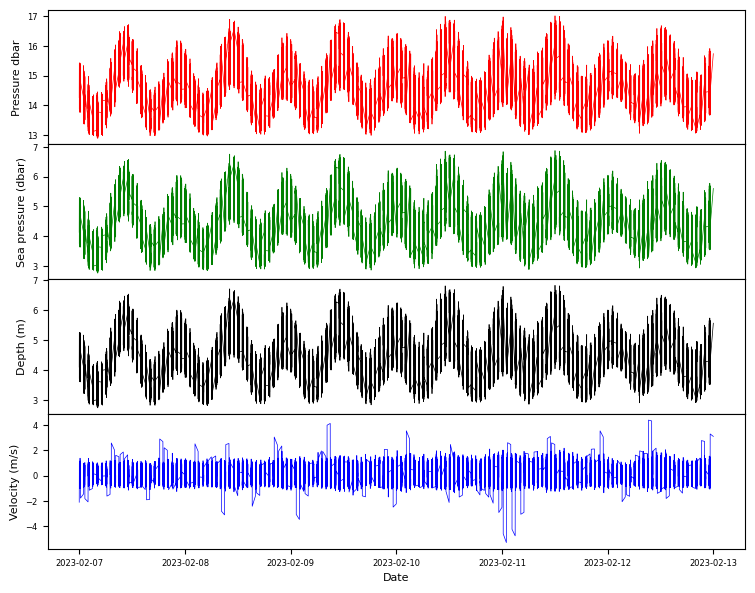

In [4]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize=(9,7), nrows=4, sharex=True, gridspec_kw={'hspace': 0})

ax0.plot(data.timestamp, data['pressure(dbar)'], lw=0.5, c='red')
ax0.tick_params(axis='both', which='major', labelsize=6)
ax0.set_ylabel('Pressure dbar', fontsize=8)

ax1.plot(data.timestamp, data['sea_pressure(dbar)'], lw=0.5, c='green')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_ylabel('Sea pressure (dbar)', fontsize=8)

ax2.plot(data.timestamp, data['depth(m)'], lw=0.5, c='k')
ax2.tick_params(axis='both', which='major', labelsize=6)
ax2.set_ylabel('Depth (m)', fontsize=8)

ax3.plot(data.timestamp, data['velocity(m/s)'], lw=0.5, c='b')
ax3.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Date', fontsize=8)
ax3.set_ylabel('Velocity (m/s)', fontsize=8)
# plt.xlim(0,len(data))
#plt.xlim(data['timestamp'][0],data['timestamp'][len(data)-1])
plt.show()

#### Note, this data was collected in 'burst' mode. 

# Step 2: Spectral analysis

## Reshape data for spectral analyses

In [5]:
# If data.timestamp is a pandas datetime column:
tvec = data['timestamp'].astype('int64') // 10**9  # to UNIX seconds
tvec = tvec.to_numpy()

# Group by hour (each hour is one burst)
groups = data.groupby(data['timestamp'].dt.floor('h'))

# For each burst, get the first and last timestamp
burst_edges = []
for _, g in groups:
    burst_edges.append(g['timestamp'].iloc[0])   # burst start
    burst_edges.append(g['timestamp'].iloc[-1])  # burst end

# Convert to UNIX epoch seconds
bursttvec = pd.to_datetime(burst_edges).astype('int64') // 10**9
bursttvec = bursttvec.to_numpy()

pvec = data['pressure(dbar)']


# Calculate Wave Spectrum

This may produce some errors. 

In [6]:
from datetime import datetime
from wave_functions import *



ws = calc_ws(
    tvec     = tvec,
    pvec     = pvec,         # pressure series
    fs       = 8.0,          # your sampling frequency
    mode     = 'wave',       #'wave' for burst mode, or 'continuous'
    bursttvec= bursttvec,    # derived from data.timestamp
    atm      = None,         # or a scalar/dict if you have atmos data
    tstart   = None,         # let function pick
    tstop    = None,         # let function pick
    zmab     = 1.5,          # sensor 1.5 m above bed 
    nfft     = 1024,          # use default
    tint     = None          # ignored for burst mode
)

C:\Users\lachl\OneDrive - The University of Sydney (Staff)\Desktop\2025_wave_processing\2025_DFAT_OTI_Hydro_Notebooks\wave_functions.py:260: RuntimeWarning: invalid value encountered in divide
  k    = k - f/dfdk
C:\Users\lachl\OneDrive - The University of Sydney (Staff)\Desktop\2025_wave_processing\2025_DFAT_OTI_Hydro_Notebooks\wave_functions.py:145: RuntimeWarning: overflow encountered in square
  PUxx[i,:] = 4 * np.pi**2 * f**2 * Pxx[i,:] * np.cosh(0)**2 / np.sinh(k*h[i])**2
C:\Users\lachl\OneDrive - The University of Sydney (Staff)\Desktop\2025_wave_processing\2025_DFAT_OTI_Hydro_Notebooks\wave_functions.py:145: RuntimeWarning: invalid value encountered in divide
  PUxx[i,:] = 4 * np.pi**2 * f**2 * Pxx[i,:] * np.cosh(0)**2 / np.sinh(k*h[i])**2
C:\Users\lachl\OneDrive - The University of Sydney (Staff)\Desktop\2025_wave_processing\2025_DFAT_OTI_Hydro_Notebooks\wave_functions.py:148: RuntimeWarning: divide by zero encountered in divide
  c        = np.sqrt(g/k*np.tanh(k*h[i]))
C:\Use

In [7]:
# usage
ws = calc_hs_from_ws(ws)

### Format the data into a Pandas Dataframe

In [8]:
def ws_to_dataframe(ws, dropna=True):
    """
    Convert ws dict (output from calc_ws) into a pandas DataFrame.

    Parameters
    ----------
    ws : dict
        Output from calc_ws
    dropna : bool, default True
        If True, drop all rows with any NaN/inf values
    """
    # Convert time vector (UNIX seconds) into pandas datetime
    time = pd.to_datetime(ws['tvec'], unit='s')

    # Pick out key series (add/remove as needed)
    data = {
        'Hs_ww': ws.get('Hs_ww'),
        'Hs_ss': ws.get('Hs_ss'),
        'Hs_ig': ws.get('Hs_ig'),
        'Hs_all': ws.get('Hs_all'),
        'Tm': ws.get('Tm'),
        'Tp': ws.get('Tp'),
        'urms': ws.get('urms'),
        'Fw': ws.get('Fw'),
        'depth': ws.get('depth')
    }

    # Build dataframe
    df = pd.DataFrame(data, index=time)

    # Replace inf values -> NaN
    df = df.replace([np.inf, -np.inf], np.nan)

    # Drop rows with any NaN if requested
    if dropna:
        df = df.dropna(how="any")

    return df
df = ws_to_dataframe(ws)

# Plot the wave heights

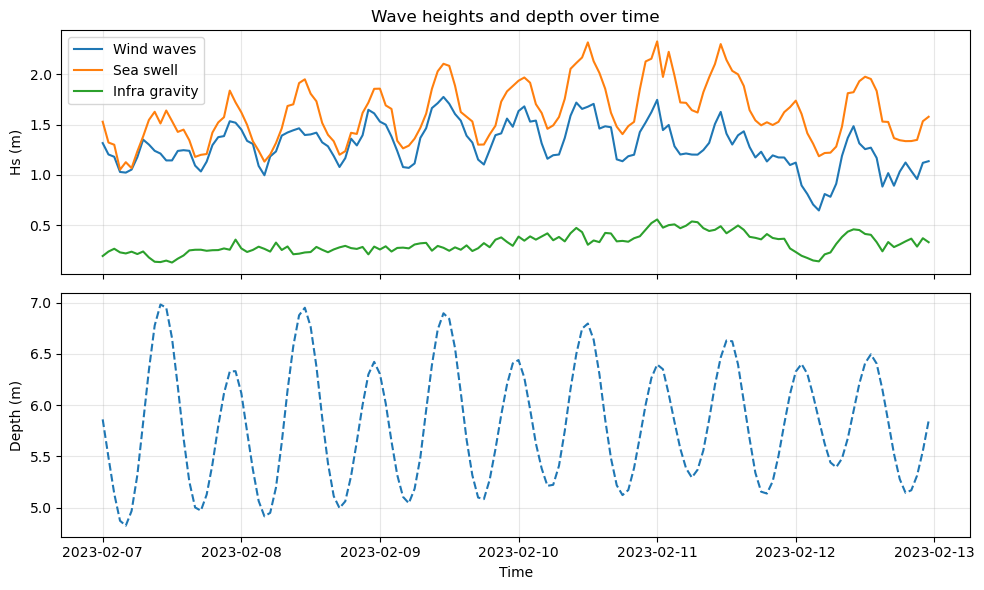

In [9]:
# Create two stacked plots that share the same x-axis (time)
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)  # 2 rows, 1 column

# ----- TOP PLOT: wave heights (Hs components) -----
ax = axes[0]                                      # pick the top axes
ax.plot(df.index, df['Hs_ww'], label='Wind waves')     # draw wind-wave Hs vs time
ax.plot(df.index, df['Hs_ss'], label='Sea swell')     # draw sea-swell Hs vs time
ax.plot(df.index, df['Hs_ig'], label='Infra gravity')     # draw infragravity Hs vs time
ax.set_ylabel('Hs (m)')                           # label for the y-axis
ax.set_title('Wave heights and depth over time')  # title for the whole figure
ax.grid(True, alpha=0.3)                          # light grid to make reading easier
ax.legend()                                       # show labels for the three lines

# ----- BOTTOM PLOT: water depth -----
ax2 = axes[1]                                     # pick the bottom axes
ax2.plot(df.index, df['depth'], linestyle='--')   # draw depth vs time (dashed line)
ax2.set_ylabel('Depth (m)')                       # label for the y-axis
ax2.set_xlabel('Time')                            # label for the shared x-axis                               # optional: deeper water appears lower
ax2.grid(True, alpha=0.3)                         # light grid for the depth plot

plt.tight_layout()                                # tidy up spacing so labels don’t overlap
plt.show()                                        # display the figure

## Plot the power spectral density


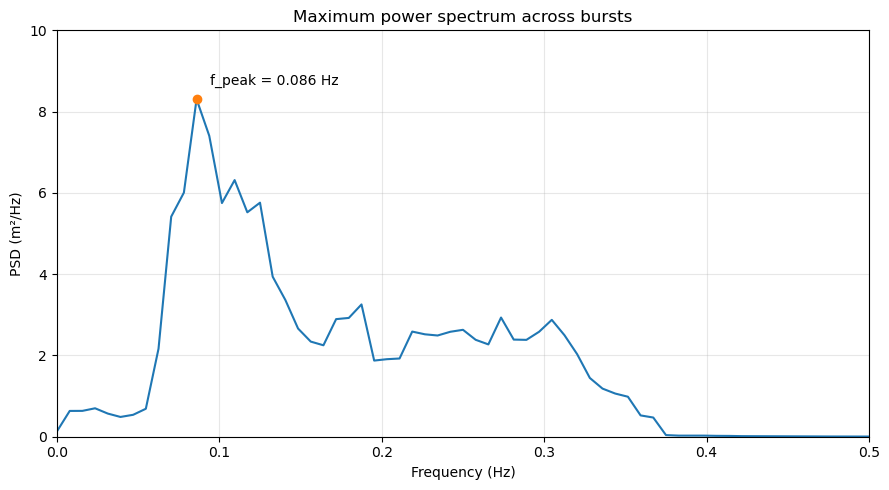

In [11]:
Pxx_max = np.nanmax(ws['Pxx'], axis=0)   # max at each frequency over time
f = ws['f']

plt.figure(figsize=(9,5))
plt.plot(f, Pxx_max)                     # <- linear scale (replaces semilogy)
plt.title("Maximum power spectrum across bursts")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (m²/Hz)")
plt.xlim(0, 0.5)
plt.ylim(0,10)
# Mark the peak frequency
f_peak = f[np.nanargmax(Pxx_max)]
p_peak = np.nanmax(Pxx_max)
plt.plot([f_peak], [p_peak], 'o')
plt.annotate(f"f_peak = {f_peak:.3f} Hz", (f_peak, p_peak),
             xytext=(10, 10), textcoords="offset points")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()